In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_context(rc={"figure.figsize": (6,3)})
import scipy.stats as stats
import sklearn
import inspect
import numpy as np
import os

os.chdir(r'C:\Users\Igor\Jupyter_Notebook_Projects\Capstone project')

from IPython.core.display import HTML
css = open('style-table.css').read() + open('style-notebook.css').read()
HTML('<style>{}</style>'.format(css))

In [2]:
# Importing CVD and RF data into a dataframe
df = pd.DataFrame.from_csv('Risk_Factors_CVD.csv', index_col=None)

In [3]:
## Cleaning data:
# Removing repetitive age categories as well as 18-24 group (null values for many factors)
# Removing 'Nutrition' topic (controversial)
# Removing 'Overall' break out and average US LocationID rows
# Selecting year - 2013 data set is most informative
# Removing Washington, DC (outlier, not a good representation)
# Removing 'Non-Hispanic Asian' group (not complete)
a = df.Break_out != '35+'
b = df.Break_out != '75+'
c = df.Break_out != '20-24'
d = df.Break_out != '18-24'
e = df.Break_out != 'Overall'
f = df.Break_out != 'Non-Hispanic Asian'
g = df.LocationAbbr != 'DC'
h = df.Year == 2013
i = df.LocationID != 0.5
j = df.Topic != 'Nutrition'

df1 = df[(a) & (b) & (c) & (d) & (e) & (f) & (g) & (h) & (i) & (j)] # creating a new df1

In [4]:
## Cleaning data:
# Removing repetitive indicators and creating new df2
list = ('post-hospitalization', 'Objective 6', 'Objective 7', 'screening', 'Objective 5', 'Objective 11', 'hypertension medication', 'Objective 8', 'Objective 9')

df2 = df1[~df.Indicator.str.contains('|'.join(list))]

C:\Users\Igor\Anaconda3\lib\site-packages\ipykernel\__main__.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.


In [5]:
## Cleaning data:
# Removing rows with null prevalence values and creating new df3
df3 = df2.dropna(subset=['Data_Value'])

In [6]:
# Renaming a few topics
df3 = df3.replace('Acute Myocardial Infarction (Heart Attack)', 'Heart_attack')
df3 = df3.replace('Coronary Heart Disease', 'CHD')
df3 = df3.replace('Physical Inactivity', 'Phys_inact')
df3 = df3.replace('Cholesterol Abnormalities', 'Cholesterol')

In [7]:
# Importing US states socioeconomic data (excluding Washingon, DC) from a csv file to a dataframe
df_us = pd.DataFrame.from_csv('USA_info_excl_DC.csv', index_col=None, encoding='cp1252')
df_us.head(5)

,LocationID,LocationDesc,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C
0,1,Alabama,32615,6271.67,0.235,0.087,41415,17.1
1,2,Alaska,61156,9127.65,0.280,0.110,60287,-3.0
2,4,Arizona,35195,5433.89,0.275,0.102,46709,15.7
3,5,Arkansas,31837,6166.94,0.211,0.075,38758,15.8
4,6,California,46029,6237.61,0.314,0.116,67458,15.2


In [8]:
# Creating new dataframes for RF and CVD including location ID, which is to be used as a key for merging
# Grouping by state and calculating mean combined prevalence values for each state
rf = df3[(df3.Category == 'Risk Factors')][['LocationID', 'Topic', 'Data_Value']].groupby(['LocationID', 'Topic']).mean()
rf = rf.unstack('Topic')['Data_Value'].reset_index()
cvd = df3[df3.Category == 'Cardiovascular Diseases'][['LocationID', 'Topic', 'Data_Value']].groupby(['LocationID', 'Topic']).mean()
cvd = cvd.unstack('Topic')['Data_Value'].reset_index()

In [9]:
cvd.head()

Topic,LocationID,CHD,Heart_attack,Stroke
0,1.0,6.666667,7.216667,5.214286
1,2.0,5.066667,4.933333,3.700000
2,4.0,5.460000,5.300000,3.720000
3,5.0,7.357143,6.383333,5.771429
4,6.0,3.537500,4.033333,2.644444


In [10]:
# Preparing Geolocation dataframe
cvdGeo = df3[df3.Category == 'Cardiovascular Diseases'][['LocationID', 'GeoLocation', 'Data_Value']].groupby(['LocationID', 'GeoLocation']).mean().reset_index()
cvdLat = cvdGeo.drop('Data_Value', 1)
#cvdLat = pd.DataFrame(cvdGeo['GeoLocation'].map(lambda x: str(x)[1:10]).astype(float))
cvdLat['GeoLocation'] = cvdLat['GeoLocation'].str.extract('(\d\d.\d\d\d\d)', expand=True)
cvdLat = cvdLat.rename(columns={'GeoLocation': 'Latitude'})
cvdLat = cvdLat.apply(lambda x: pd.to_numeric(x, errors='ignore'))

cvdLon = cvdGeo.drop('Data_Value', 1)
#cvdLon = pd.DataFrame(cvdGeo['GeoLocation'].map(lambda x: str(x)[-20:-6]).astype(float))
cvdLon['GeoLocation'] = cvdLon['GeoLocation'].str.extract('(-[0-9]{1,3}.\d\d\d\d)', expand=True)
cvdLon = cvdLon.rename(columns={'GeoLocation': 'Longitude'})
cvdLon = cvdLon.apply(lambda x: pd.to_numeric(x, errors='ignore'))

cvdLatLon = pd.merge(cvdLat, cvdLon, on='LocationID', how='inner')

cvdLatLon.head()

,LocationID,Latitude,Longitude
0,1.0,32.8405,-86.6318
1,2.0,64.8450,-147.7220
2,4.0,34.8659,-111.7638
3,5.0,34.7486,-92.2744
4,6.0,37.6386,-120.9999


In [11]:
# Creating a dataframe combining geolocation data with US states socioeconomic data
df_us_del = df_us.drop('LocationDesc', axis=1)
df_us_geo = pd.merge(df_us_del, cvdLatLon, on='LocationID', how='inner')
df_us_geo.head()

,LocationID,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude
0,1,32615,6271.67,0.235,0.087,41415,17.1,32.8405,-86.6318
1,2,61156,9127.65,0.280,0.110,60287,-3.0,64.8450,-147.7220
2,4,35195,5433.89,0.275,0.102,46709,15.7,34.8659,-111.7638
3,5,31837,6166.94,0.211,0.075,38758,15.8,34.7486,-92.2744
4,6,46029,6237.61,0.314,0.116,67458,15.2,37.6386,-120.9999


In [12]:
# Merging dataframes to include US states data with CVD and RF
df_merged_cvd_rf = pd.merge(cvd, rf, on='LocationID', how='inner')
df_merged = pd.merge(df_us_geo, df_merged_cvd_rf, on='LocationID', how='inner')
df_merged.head()

,LocationID,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,CHD,Heart_attack,Stroke,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking
0,1,32615,6271.67,0.235,0.087,41415,17.1,32.8405,-86.6318,6.666667,7.216667,5.214286,41.925000,15.414286,40.611111,33.175000,31.777778,21.414286
1,2,61156,9127.65,0.280,0.110,60287,-3.0,64.8450,-147.7220,5.066667,4.933333,3.700000,37.044444,8.757143,36.666667,31.677778,24.650000,21.566667
2,4,35195,5433.89,0.275,0.102,46709,15.7,34.8659,-111.7638,5.460000,5.300000,3.720000,39.687500,12.622222,34.522222,28.975000,27.000000,15.871429
3,5,31837,6166.94,0.211,0.075,38758,15.8,34.7486,-92.2744,7.357143,6.383333,5.771429,40.966667,12.914286,39.655556,36.675000,35.977778,24.662500
4,6,46029,6237.61,0.314,0.116,67458,15.2,37.6386,-120.9999,3.537500,4.033333,2.644444,38.177778,12.544444,33.255556,24.977778,22.511111,12.211111


In [13]:
df_merged.shape

(50, 18)

## Linear Regression for CHD

In [41]:
# Creating a dataframe with features (predictors) to be analyzed
df_X = df_merged.drop(df_merged.ix[:,'CHD':'Stroke'].head(0).columns, 1)
df_X = df_X.drop('LocationID', 1)

In [42]:
# Defining independent and dependent variables for regression
X = df_X.values       #iloc[:,1:].values #reshape(-1, 1)
Y = df_merged['CHD'].values #reshape(-1, 1)

In [43]:
df_X.head()

,GDP_2012,Healthcare_spending_2009,Bachelor_degree,Advanced_degree,Median_household_income_2014,Average_annual_Temp_C,Latitude,Longitude,Cholesterol,Diabetes,Hypertension,Obesity,Phys_inact,Smoking
0,32615,6271.67,0.235,0.087,41415,17.1,32.8405,-86.6318,41.925000,15.414286,40.611111,33.175000,31.777778,21.414286
1,61156,9127.65,0.280,0.110,60287,-3.0,64.8450,-147.7220,37.044444,8.757143,36.666667,31.677778,24.650000,21.566667
2,35195,5433.89,0.275,0.102,46709,15.7,34.8659,-111.7638,39.687500,12.622222,34.522222,28.975000,27.000000,15.871429
3,31837,6166.94,0.211,0.075,38758,15.8,34.7486,-92.2744,40.966667,12.914286,39.655556,36.675000,35.977778,24.662500
4,46029,6237.61,0.314,0.116,67458,15.2,37.6386,-120.9999,38.177778,12.544444,33.255556,24.977778,22.511111,12.211111


In [44]:
# Random 80:20 split for training:testing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40, 14)
(10, 14)
(40,)
(10,)


In [45]:
# Create an instance of the linear regression model.
lm = LinearRegression()

# Now, train the model with all the 8 predictors only using the training set
lm.fit(X_train, Y_train)

# First, we can check to see how much of the variance in the training data is captured by the model.
# We can compute R-squared for this.
from sklearn.metrics import r2_score
print("R-squared for training data: ")
print(r2_score(Y_train, lm.predict(X_train)))

print("R-squared for test data: ")
print(r2_score(Y_test, lm.predict(X_test)))
print()

# Predict the output on the test set and print the first five values
print("predictions for 5 states in the test set:")
print(lm.predict(X_test)[0:5])

# Look at the mean squared error on the test set first and then on the training set.
from sklearn.metrics import mean_squared_error
print("Mean squared error on the test set: ")
print(mean_squared_error(Y_test, lm.predict(X_test)))
print("Mean squared error on the training set: ")
print(mean_squared_error(Y_train, lm.predict(X_train)))

R-squared for training data: 
0.735583896422
R-squared for test data: 
0.610460606066

predictions for 5 states in the test set:
[ 5.35876534  4.78956993  4.44047257  4.77290766  4.72836337]
Mean squared error on the test set: 
0.438345425883
Mean squared error on the training set: 
0.286362269312


In [46]:
lm.score(X, Y)

0.70980716846576697

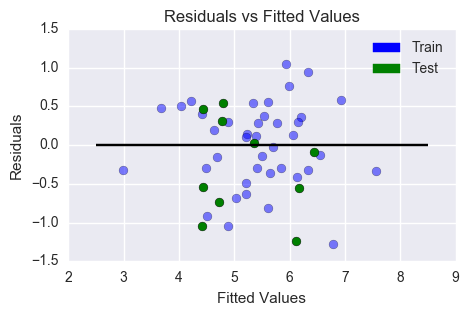

In [47]:
import matplotlib.patches as mpatches

plt.figure(figsize=(5,3))
plt.scatter(lm.predict(X_train), lm.predict(X_train) - Y_train, c='b', s=40, alpha=0.5)
plt.scatter(lm.predict(X_test), lm.predict(X_test) - Y_test, c='g', s=40)
plt.hlines(y = 0, xmin=2.5, xmax = 8.5)
#plt.title('Residual Plot using training (blue) and test (green) data')
plt.title('Residuals vs Fitted Values')
plt.ylabel('Residuals')
plt.xlabel('Fitted Values')

blue_patch = mpatches.Patch(color='b', label='Train')
green_patch = mpatches.Patch(color ='g', label='Test')
plt.legend(handles=[blue_patch, green_patch])

In [48]:
# Import regression modules
# ols - stands for Ordinary least squares, we'll use this
import statsmodels.api as sm
#from statsmodels.formula.api import ols
import statsmodels.api as sm
Y = stats.zscore(Y_train)
X = stats.zscore(X_train)
m = sm.OLS(Y,X).fit()
print(m.summary())
print()
Y = stats.zscore(Y_train)
X = stats.zscore(X_train)
m2 = sm.OLS(Y,X).fit()
print(m2.summary())

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.736
Model:                            OLS   Adj. R-squared:                  0.593
Method:                 Least Squares   F-statistic:                     5.166
Date:                Tue, 28 Feb 2017   Prob (F-statistic):           0.000156
Time:                        10:25:57   Log-Likelihood:                -30.153
No. Observations:                  40   AIC:                             88.31
Df Residuals:                      26   BIC:                             112.0
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
x1             0.0380      0.197      0.193      0.8

## Random Forest for CHD

In [49]:
from sklearn.ensemble import RandomForestRegressor

# Create an instance of the Random Forest model.
rf = RandomForestRegressor(random_state = 1)

# Now, train the model with all the 8 predictors only using the training set
rf.fit(X_train, Y_train)
#rf.predict(X_train)

# First, we can check to see how much of the variance in the training data is captured by the model.
# We can compute R-squared for this (also referred to as the coefficient of determination).
print("R-squared for training data: ")
print(rf.score(X_train,Y_train))
print()
print("R-squared for test data: ")
print(rf.score(X_test,Y_test))
print()

# Predict the output on the test set and print the first five values
print("predictions for 5 five states in the test set:")
print(rf.predict(X_test)[0:5])
print()

# Look at the mean squared error on the test set first and then on the training set.
from sklearn.metrics import mean_squared_error
print("Mean squared error on the test set: ")
print(mean_squared_error(Y_test, rf.predict(X_test)))
print("Mean squared error on the training set: ")
print(mean_squared_error(Y_train, rf.predict(X_train)))

R-squared for training data: 
0.892676678891

R-squared for test data: 
0.707202873384

predictions for 5 five states in the test set:
[ 5.55252381  5.16278571  4.49141667  5.23921429  4.69688095]

Mean squared error on the test set: 
0.329482160629
Mean squared error on the training set: 
0.116231006232


In [50]:
from sklearn.model_selection import KFold, cross_val_score
k_fold = KFold(n_splits=5)
for train_indices, test_indices in k_fold.split(X):
    print('Train: %s | test: %s' % (train_indices, test_indices))

Train: [ 8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39] | test: [0 1 2 3 4 5 6 7]
Train: [ 0  1  2  3  4  5  6  7 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39] | test: [ 8  9 10 11 12 13 14 15]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 24 25 26 27 28 29 30 31 32
 33 34 35 36 37 38 39] | test: [16 17 18 19 20 21 22 23]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 32
 33 34 35 36 37 38 39] | test: [24 25 26 27 28 29 30 31]
Train: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31] | test: [32 33 34 35 36 37 38 39]


In [51]:
kfold = KFold(n_splits=5)
[rf.fit(X[train], Y[train]).score(X[test], Y[test]) for train, test in kfold.split(X)]

[0.4658178919891221,
 0.35531051859894647,
 -0.29598906974974271,
 -0.46057409946462657,
 0.70483685675881813]

In [39]:
# Relative importance of features
fimp = rf.feature_importances_
fimp

array([ 0.03822547,  0.01719981,  0.0085498 ,  0.03725418,  0.07973965,
        0.03612938,  0.00242765,  0.009842  ,  0.14011473,  0.00773195,
        0.26153409,  0.13996095,  0.00462984,  0.2166605 ])

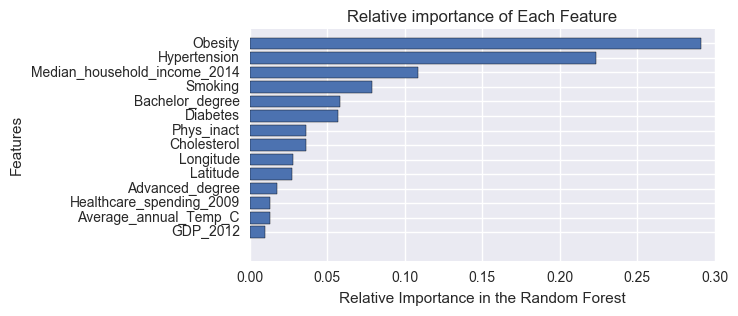

In [27]:
# Plotting ranked features
name_list = df_X.columns
fimp, name_list = zip(*sorted(zip(fimp, name_list)))
plt.barh(range(len(name_list)),fimp,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

## Random Forest for Heart Attack

In [28]:
# Defining independent and dependent variables for regression
X = df_X.values
Y = df_merged['Heart_attack'].values

In [29]:
# Random 80:20 split for training:testing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40, 14)
(10, 14)
(40,)
(10,)


In [30]:
# Create an instance of the Random Forest model.
rf = RandomForestRegressor(random_state = 1)

# Now, train the model with all the 8 predictors only using the training set
rf.fit(X_train, Y_train)
#rf.predict(X_train)

# First, we can check to see how much of the variance in the training data is captured by the model.
# We can compute R-squared for this (also referred to as the coefficient of determination).
print("R-squared for training data: ")
print(rf.score(X_train,Y_train))
print()
print("R-squared for test data: ")
print(rf.score(X_test,Y_test))
print()

# Predict the output on the test set and print the first five values
print("predictions for 5 five states in the test set:")
print(rf.predict(X_test)[0:5])
print()

# Look at the mean squared error on the test set first and then on the training set.
from sklearn.metrics import mean_squared_error
print("Mean squared error on the test set: ")
print(mean_squared_error(Y_test, rf.predict(X_test)))
print("Mean squared error on the training set: ")
print(mean_squared_error(Y_train, rf.predict(X_train)))

R-squared for training data: 
0.883026363145

R-squared for test data: 
0.61688027203

predictions for 5 five states in the test set:
[ 5.95333333  4.52505952  4.4764881   4.68023413  4.2047381 ]

Mean squared error on the test set: 
0.261911588029
Mean squared error on the training set: 
0.128987185015


In [31]:
# Relative importance of features
fimp = rf.feature_importances_
fimp

array([ 0.01719958,  0.02753011,  0.17032877,  0.3233191 ,  0.06122576,
        0.00353413,  0.00862843,  0.02039921,  0.00784543,  0.0021564 ,
        0.09736461,  0.04847605,  0.09465962,  0.11733281])

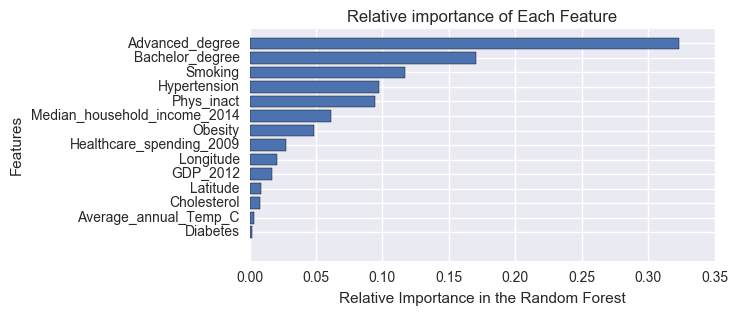

In [32]:
# Plotting ranked features
name_list = df_X.columns
fimp, name_list = zip(*sorted(zip(fimp, name_list)))
plt.barh(range(len(name_list)),fimp,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()

## Random Forest for Stroke

In [33]:
# Defining independent and dependent variables for regression
X = df_X.values
Y = df_merged['Stroke'].values

In [34]:
# Random 80:20 split for training:testing
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split


X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.20, random_state = 5)
print(X_train.shape)
print(X_test.shape)
print(Y_train.shape)
print(Y_test.shape)

(40, 14)
(10, 14)
(40,)
(10,)


In [35]:
# Create an instance of the Random Forest model.
rf = RandomForestRegressor(random_state = 1)

# Now, train the model with all the 8 predictors only using the training set
rf.fit(X_train, Y_train)
#rf.predict(X_train)

# First, we can check to see how much of the variance in the training data is captured by the model.
# We can compute R-squared for this (also referred to as the coefficient of determination).
print("R-squared for training data: ")
print(rf.score(X_train,Y_train))
print()
print("R-squared for test data: ")
print(rf.score(X_test,Y_test))
print()

# Predict the output on the test set and print the first five values
print("predictions for 5 five states in the test set:")
print(rf.predict(X_test)[0:5])
print()

# Look at the mean squared error on the test set first and then on the training set.
from sklearn.metrics import mean_squared_error
print("Mean squared error on the test set: ")
print(mean_squared_error(Y_test, rf.predict(X_test)))
print("Mean squared error on the training set: ")
print(mean_squared_error(Y_train, rf.predict(X_train)))

R-squared for training data: 
0.896494936695

R-squared for test data: 
0.682047543479

predictions for 5 five states in the test set:
[ 3.72558333  3.13533333  2.97934921  3.16140476  3.06738492]

Mean squared error on the test set: 
0.277858917796
Mean squared error on the training set: 
0.0520358452117


In [36]:
# Relative importance of features
fimp = rf.feature_importances_
fimp

array([ 0.03743626,  0.01300847,  0.01632834,  0.00815211,  0.05706818,
        0.03738945,  0.00739599,  0.01970379,  0.06129206,  0.03878986,
        0.28888758,  0.10812136,  0.06992428,  0.23650227])

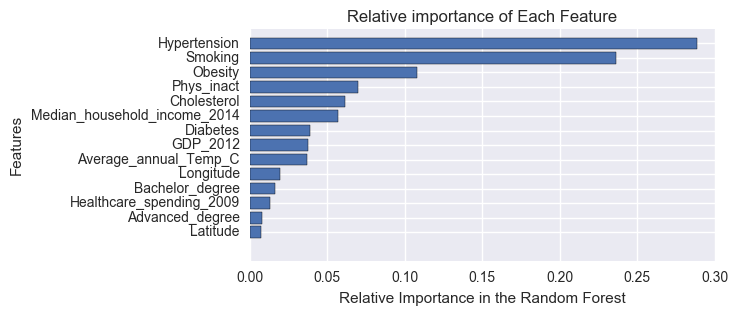

In [37]:
# Plotting ranked features
name_list = df_X.columns
fimp, name_list = zip(*sorted(zip(fimp, name_list)))
plt.barh(range(len(name_list)),fimp,align='center')
plt.yticks(range(len(name_list)),name_list)
plt.xlabel('Relative Importance in the Random Forest')
plt.ylabel('Features')
plt.title('Relative importance of Each Feature')
plt.show()